# Assignment 2

## First draft
### Youssef Ragab, Ting Huang, Garrett Hastings, Jaime Sarmiento


**1. Loading in the required libraries:**

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt 
import h2o 
from h2o.estimators.gbm import H2OGradientBoostingEstimator 
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch 
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator 
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.frame import H2OFrame      
import itertools       
import matplotlib.pyplot as plt        
import xgboost as xgb 
import time 
import seaborn as sns 
import numpy as np
import datetime
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.perf import ROC

Initializations: 

In [4]:
Seed = 2021

nthreads = 4

h2o.init(max_mem_size= '6G', nthreads= nthreads)
h2o.remove_all()
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,8 days 4 hours 15 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_tinghuang_rodxig
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.156 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Start global timer:

In [5]:
tic = time.time()

Importing data: 

In [6]:
train = pd.read_csv('hmda_train_preprocessed.csv')
test = pd.read_csv('hmda_test_preprocessed.csv')

In [7]:
train.columns

Index(['row_id', 'black', 'asian', 'white', 'amind', 'hipac', 'hispanic',
       'non_hispanic', 'male', 'female', 'agegte62', 'agelt62', 'term_360',
       'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std',
       'loan_to_value_ratio_std', 'no_intro_rate_period_std',
       'intro_rate_period_std', 'property_value_std', 'income_std',
       'debt_to_income_ratio_std', 'high_priced'],
      dtype='object')

In [8]:
test.columns

Index(['row_id', 'black', 'asian', 'white', 'amind', 'hipac', 'hispanic',
       'non_hispanic', 'male', 'female', 'agegte62', 'agelt62', 'term_360',
       'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std',
       'loan_to_value_ratio_std', 'no_intro_rate_period_std',
       'intro_rate_period_std', 'property_value_std', 'income_std',
       'debt_to_income_ratio_std'],
      dtype='object')

Now that we have the datasets loaded, we can proceed and remove the columns that we don't need from the training set. Based on the assignment prompt, we are going to keep the following variables:
* high_priced
* conforming 
* debt_to_income_ratio_std
* debt_to_income_ratio_missing
* income_std 
* loan_amount_std
* intro_rate_period_std
* loan_to_value_ratio_std
* no_intro_rate_period_std
* property_value_std
* term_360

In [11]:
x_name = ['conforming', 'debt_to_income_ratio_std', 'debt_to_income_ratio_missing', 'income_std', 'loan_amount_std', 'intro_rate_period_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std', 'property_value_std', 'term_360']
y_name = 'high_priced'

### Fitting interpretable models: 

**Splitting data into training and validation subsets:**

In [12]:
np.random.seed(Seed)

split_ratio = 0.7

split = np.random.rand(len(train)) < split_ratio

training = train[split]
validation = train[~split]

print('Train data rows = %d, columns = %d' % (training.shape[0], training.shape[1]))
print('Train data rows = %d, columns = %d' % (validation.shape[0], validation.shape[1])) 


Train data rows = 112085, columns = 23
Train data rows = 48253, columns = 23


### Elastic Net

**Defining wrapper function for hyperparameter grid search:**

In [9]:
def glm_grid(x_name, y_name, htrain, hvalid, seed):

    # Creating alpha options to set L2:
    alpha_options = [0.1, 0.25, 0.5, 0.99]
    
    # Defining serch criteria
    hyperparameters = {'alpha': alpha_options}

    # Initializing grid 
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(family = 'binomial',
                                      lambda_search = True,
                                      seed = seed),
        hyper_params = hyperparameters)

    # Executing training with grid search
    grid.train(y = y_name,
               x = x_name,
               training_frame = htrain, 
               validation_frame = hvalid,
               seed = seed)

    # Choosing the best model from the grid seach 
    best_model = grid.get_grid()[0]
    del grid 

    return best_model


**Fitting elastic net with grid search**

In [10]:
# Start timer 
glm_tic = time.time()

# Converting data into H2O Frame 
htrain = h2o.H2OFrame(training)
hvalid = h2o.H2OFrame(validation)

# Training with grid search 
best_glm = glm_grid(x_name, y_name, htrain, hvalid, Seed)

# End timer 
glm_toc = time.time() - glm_tic
print('Elastic net GLM training completed in %.2f s.' % glm_toc)

Elastic net GLM training completed in 12.09 s.


**Basic AUC assessment:**

In [11]:
print('Validation AUC: %.4f.' % best_glm.auc(valid = True))

Validation AUC: 0.7563.


**Score validation data with model**

In [12]:
best_glm_submit = best_glm.predict(h2o.H2OFrame(test)).as_data_frame()
best_glm_submit.drop(['predict', 'p0'], axis = 1, inplace = True)
best_glm_submit.columns = ['phat']
best_glm_submit = pd.concat([validation.reset_index(drop=True), best_glm_submit], axis=1)
best_glm_submit.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.118642,0.268727,0.244394,-0.215304,-0.227585,-0.018133,-0.425131,0,0.143552
1,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,-0.602338,0.552520,0.244394,-0.215304,-0.628437,-0.038228,0.763191,0,0.081619
2,7,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,-0.734255,0.552520,0.244394,-0.215304,-0.720941,-0.039614,0.488963,0,0.128237
3,9,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,1.332446,-0.261719,0.244394,-0.215304,1.190815,0.075764,-1.156406,0,0.005958
4,12,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.024369,-0.425131,1,0.131587


#### Utility function for selecting percentiles

In [13]:
def get_percentile_dict(yhat_name, frame, id_):

    """ Returns the percentiles of a column, yhat_name, as the indices based on
        another column id_.
        :param yhat_name: Name of column in frame in which to find percentiles.
        :param frame: Pandas frame.
        :param id_: Validation Pandas frame containing yhat and id_.
        :return: Dictionary of percentile values and index column values.
    """

    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat_name, inplace=True)
    sort_df.reset_index(inplace=True)

    # find top and bottom percentiles
    percentiles_dict = {0: sort_df.loc[0, id_], 99: sort_df.loc[sort_df.shape[0] - 1, id_]}

    # find 10th-90th percentiles
    inc = sort_df.shape[0] // 10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc, id_]

    return percentiles_dict

#### Select percentiles from predictions

In [14]:
best_glm_percentiles = get_percentile_dict('phat', best_glm_submit, 'row_id')
for key in sorted(best_glm_percentiles.keys()):
    print(str(key) + ': ' + str(best_glm_percentiles[key]))

0: 15340
10: 65757
20: 42634
30: 49003
40: 20879
50: 80111
60: 96502
70: 112762
80: 128906
90: 144457
99: 160335


#### Collect global feature importance info

In [15]:
# use coefficients as relative global feature importance
global_feat_imp = pd.DataFrame.from_dict(best_glm.coef(), columns=['GLM Importance'], orient='index')
global_feat_imp.drop('Intercept', inplace=True)
global_feat_imp['GLM Importance'] = np.abs(global_feat_imp['GLM Importance'])

In [ ]:
global_feat_imp

#### Collect local feature importance info

In [16]:
# use (coefficient * value) as local feature importance

# init frame to store local contribs
local_fi_dict = {10: pd.DataFrame(columns = ['GLM Contribution'], index=x_name),
                 50: pd.DataFrame(columns = ['GLM Contribution'], index=x_name),
                 90: pd.DataFrame(columns = ['GLM Contribution'], index=x_name)}

# get (coefficient * value) at three percentiles of phat
for name in x_name:
    for percentile in [10, 50, 90]:
    
        # local contributions = beta_j * x_i,j
        local_fi_dict[percentile].loc[name, 'GLM Contribution'] =\
            best_glm.coef()[name] *\
            validation[validation['row_id'] == int(best_glm_percentiles[percentile])][name].values[0]

In [17]:
#local_fi_dict[10]
local_fi_dict[50]
#local_fi_dict[90]

,GLM Contribution
conforming,0.0
debt_to_income_ratio_std,0.131437
debt_to_income_ratio_missing,0.0
income_std,0.0
loan_amount_std,0.0
intro_rate_period_std,0.0
loan_to_value_ratio_std,-0.050047
no_intro_rate_period_std,-0.0
property_value_std,-2.20074
term_360,0.222036


### Monotonic XGBoost
**Define utility function for random grid search**

In [18]:
def xgb_grid(dtrain, dvalid, mono_constraints=None, gs_params=None, n_models=None,
             ntree=None, early_stopping_rounds=None, verbose=False, seed=None):
    

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(Seed) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for objective,  etc.
    params = {'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': nthreads,
              'objective': 'binary:logistic',
              'seed': Seed}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train on current params
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        
        if mono_constraints is not None:
            params['monotone_constraints'] = mono_constraints
        
        candidate = xgb.train(params,
                              dtrain,
                              ntree,
                              early_stopping_rounds=early_stopping_rounds,
                              evals=watchlist,
                              verbose_eval=verbose)    

        # determine if current model is better than previous best
        if candidate.best_score > best_score:
            best_candidate = candidate
            best_score = candidate.best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate.best_score))

        print('---------- ----------')
            
    return best_candidate

**Fit monotonic XGBoost with random grid search**

In [19]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
             'colsample_bylevel': [0.3, 0.5, 0.7, 0.9],
             'eta': [0.005, 0.05, 0.5],
             'max_depth': [3, 5, 7],
             'reg_alpha': [0.0005, 0.005, 0.05],
             'reg_lambda': [0.0005, 0.005, 0.05],
             'subsample': [0.3, 0.5, 0.7, 0.9],
             'min_child_weight': [1, 5, 10], 
             'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4]}

# define monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train[x_name + [y_name]].corr()[y_name].values[:-1])])

# start local timer
mxgb_tic = time.time()

# Convert data to SVMLight format
dtrain = xgb.DMatrix(training[x_name], training[y_name])
dvalid = xgb.DMatrix(validation[x_name], validation[y_name])

# Monotonic XGBoost grid search
best_mxgb = xgb_grid(dtrain, dvalid, gs_params=gs_params, n_models=50, ntree=1000, early_stopping_rounds=100, 
                     mono_constraints=mono_constraints, seed=Seed)

# end local timer
mxgb_toc = time.time() - mxgb_tic
print('Monotonic GBM training completed in %.2f s.' % (mxgb_toc))

Grid search run 1/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 2021, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.5, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.5, 'min_child_weight': 5, 'gamma': 0.1}
Grid search new best score discovered at iteration 1/50: 0.7717.
---------- ----------
Grid search run 2/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 2021, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.4, 'monotone_constraints': (1, 1, 1, -1, -1, -1, 1, 1, -1, 1)}
Grid search new best score discovered at iteration 2/50: 0.7871.
---------- ----------
Grid search run 3/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'obj

Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 2021, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.9, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.05, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.2, 'monotone_constraints': (1, 1, 1, -1, -1, -1, 1, 1, -1, 1)}
---------- ----------
Grid search run 40/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 2021, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.2, 'monotone_constraints': (1, 1, 1, -1, -1, -1, 1, 1, -1, 1)}
---------- ----------
Grid search run 41/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 2021, 'colsample_bytree': 0.9, 'colsample_bylevel'

**Basic AUC assessment**

In [20]:
print('Validation AUC: %.4f.' % best_mxgb.best_score)

Validation AUC: 0.7913.


**Score validation data with model**

In [21]:
dtest = xgb.DMatrix(test[x_name])
best_mxgb_submit = pd.DataFrame(best_mxgb.predict(dtest, ntree_limit=best_mxgb.best_ntree_limit), columns=['phat'])
best_mxgb_submit = pd.concat([validation.reset_index(drop=True), best_mxgb_submit], axis=1)
best_mxgb_submit.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.118642,0.268727,0.244394,-0.215304,-0.227585,-0.018133,-0.425131,0,0.066214
1,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,-0.602338,0.552520,0.244394,-0.215304,-0.628437,-0.038228,0.763191,0,0.034362
2,7,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,-0.734255,0.552520,0.244394,-0.215304,-0.720941,-0.039614,0.488963,0,0.171752
3,9,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,1.332446,-0.261719,0.244394,-0.215304,1.190815,0.075764,-1.156406,0,0.031721
4,12,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.024369,-0.425131,1,0.176927


#### Select percentiles from predictions

In [22]:
best_mxgb_percentiles = get_percentile_dict('phat', best_mxgb_submit, 'row_id')
for key in sorted(best_mxgb_percentiles.keys()):
    print(str(key) + ': ' + str(best_mxgb_percentiles[key]))

0: 47749
10: 41732
20: 46289
30: 37296
40: 318
50: 80111
60: 96502
70: 112762
80: 128906
90: 144457
99: 160335


#### Calculate Shapley values

In [25]:
shapley_contribs = best_mxgb.predict(dvalid, pred_contribs=True, iteration_range=(0, best_mxgb.best_ntree_limit))

TypeError: predict() got an unexpected keyword argument 'iteration_range'

#### Collect global feature importance info

In [24]:
# use mean abs SHAP as feature importance
shapley_contribs_df = pd.DataFrame(shapley_contribs, columns=x_name + ['intercept'])
global_feat_imp['MXGB Importance'] = np.abs(shapley_contribs_df.drop('intercept', axis=1)).mean()

NameError: name 'shapley_contribs' is not defined

#### Collect local feature importance info

In [26]:
# create mapping between validation row_id and Shapely array index values
valid_idx_map = validation['row_id'].copy(deep=True)
valid_idx_map.reset_index(drop=True, inplace=True)

# collect SHAP values at three percentiles of phat
for percentile in [10, 50, 90]:

    # using valid_idx_map and percentiles dict
    # to find the right local contributions
    idx = valid_idx_map[valid_idx_map == int(best_mxgb_percentiles[percentile])].index[0]
    s_df = pd.DataFrame(shapley_contribs[idx, :-1].T, columns=['MXGB Contribution'], index=x_name)
    local_fi_dict[percentile]['MXGB Contribution'] = 0
    local_fi_dict[percentile].update(s_df)

NameError: name 'shapley_contribs' is not defined

### Random forest 

In [9]:
def feature_combiner(training_frame, test_frame, nums):
    
    """ Combines numeric features using simple arithmatic operations.
    
    :param training_frame: Training frame from which to generate features and onto which generated 
                           feeatures will be cbound.
    :param test_frame: Test frame from which to generate features and onto which generated 
                       feeatures will be cbound.
    :param nums: List of original numeric features from which to generate combined features.
    
    """

    total = len(nums)
    
    # convert to pandas
    train_df = training_frame.as_data_frame()
    test_df = test_frame.as_data_frame()
    
    for i, col_i in enumerate(nums):
        
        print('Combining: ' + col_i + ' (' + str(i+1) + '/' + str(total) + ') ...')        
        
        for j, col_j in enumerate(nums):
            
            # don't repeat (i*j = j*i)
            if i < j:
                
                # convert to pandas
                col_i_train_df = train_df[col_i]
                col_j_train_df = train_df[col_j]
                col_i_test_df = test_df[col_i]
                col_j_test_df = test_df[col_j] 

                # multiply, convert back to h2o
                train_df[str(col_i + '|' + col_j)] = col_i_train_df.values*col_j_train_df.values
                test_df[str(col_i + '|' + col_j)] = col_i_test_df.values*col_j_test_df.values
                
    print('Done.')
    
    # convert back to h2o
    
    print('Converting to H2OFrame ...')
    
    training_frame = h2o.H2OFrame(train_df)
    training_frame.columns = list(train_df)
    test_frame = h2o.H2OFrame(test_df)
    test_frame.columns = list(test_df)
    
    print('Done.')
    print()
    
    # conserve memory 
    del train_df
    del test_df 
    
    return training_frame, test_frame

In [13]:
H2OFrame(training[x_name])

conforming,debt_to_income_ratio_std,debt_to_income_ratio_missing,income_std,loan_amount_std,intro_rate_period_std,loan_to_value_ratio_std,no_intro_rate_period_std,property_value_std,term_360
1,0.854601,0,-0.0403074,-0.514393,-0.215304,0.333922,0.244394,-0.535932,1
1,0.123326,0,-0.0323383,-0.778227,4.61086,0.228996,-4.09175,-0.720941,1
1,-0.425131,0,-0.0181326,-0.0746695,-0.215304,-1.15024,0.244394,0.358276,1
1,0.397554,0,-0.0247158,-0.338504,-0.215304,0.372784,0.244394,-0.412593,1
1,1.03742,0,-0.0209045,-0.426448,-0.215304,0.355249,0.244394,-0.474263,1
1,0.0319161,0,-0.019865,0.277109,-0.215304,0.142995,0.244394,0.111598,1
1,0.94601,0,-0.0281806,-0.382476,-0.215304,-0.240432,0.244394,-0.320089,1
1,-1.15641,0,0.0165154,0.10122,-0.215304,-0.266529,0.244394,0.111598,1
1,-1.15641,0,0.00300267,-0.0746695,-0.215304,0.154744,0.244394,-0.165915,1
1,-1.15641,0,-0.0274876,-0.426448,-0.215304,0.355249,0.244394,-0.474263,1


In [14]:
rf_model1 = H2ORandomForestEstimator(
    ntrees=10000,                    
    max_depth=10, 
    col_sample_rate_per_tree=0.1,
    sample_rate=0.8,
    stopping_rounds=50,
    score_each_iteration=True,
    nfolds=3,
    keep_cross_validation_predictions=True,
    seed=12345)           

# start timer 
rf_tic = time.time()

# train rf model
rf_model1.train(
    y = 'high_priced',
    training_frame=H2OFrame(training),
    validation_frame=H2OFrame(validation))

# print model information
rf_toc = time.time() - rf_tic
print('Random Forest training completed in %.2f s.' % rf_toc)
print(rf_model1)


rf_preds1_test = rf_model1.predict(H2OFrame(test))
gen_submission(rf_preds1_test) # 0.14574 public leaderboard

Random Forest training completed in 290.15 s.
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1622323420230_38


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,169.0,169.0,234725.0,1.0,10.0,6.538462,2.0,645.0,106.27811




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.08401823604028531
RMSE: 0.2898589933748569
MAE: 0.1709055040776233
RMSLE: 0.20149013901240773
Mean Residual Deviance: 0.08401823604028531

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.08377993383950061
RMSE: 0.2894476357469527
MAE: 0.1706729649766333
RMSLE: 0.201178220406609
Mean Residual Deviance: 0.08377993383950061

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.08398448758353348
RMSE: 0.2898007722272898
MAE: 0.17091280284350568
RMSLE: 0.20142187997144373
Mean Residual Deviance: 0.08398448758353348

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
0,mae,0.17091016,6.077121E-4,0.17122616,0.17020956,0.17129476
1,mean_residual_deviance,0.083979465,0.001110113,0.08466046,0.08269847,0.08457946
2,mse,0.083979465,0.001110113,0.08466046,0.08269847,0.08457946
3,r2,0.03909461,4.6772946E-4,0.039032564,0.039590262,0.038660996
4,residual_deviance,0.083979465,0.001110113,0.08466046,0.08269847,0.08457946
5,rmse,0.28978786,0.0019190358,0.2909647,0.28757343,0.2908255
6,rmsle,0.20141469,0.001129356,0.20209084,0.20011093,0.20204231



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2021-06-06 21:43:32,3 min 14.292 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-06-06 21:43:32,3 min 14.315 sec,1.0,0.296120,0.172386,0.087687,0.292067,0.170101,0.085303
2,,2021-06-06 21:43:32,3 min 14.338 sec,2.0,0.294800,0.172927,0.086907,0.292631,0.172245,0.085633
3,,2021-06-06 21:43:32,3 min 14.369 sec,3.0,0.294625,0.173148,0.086804,0.293046,0.172685,0.085876
4,,2021-06-06 21:43:32,3 min 14.398 sec,4.0,0.294375,0.172940,0.086656,0.292724,0.172412,0.085687
5,,2021-06-06 21:43:32,3 min 14.445 sec,5.0,0.294752,0.173092,0.086879,0.292193,0.172106,0.085377
6,,2021-06-06 21:43:32,3 min 14.500 sec,6.0,0.294706,0.172977,0.086852,0.291980,0.171951,0.085252
7,,2021-06-06 21:43:32,3 min 14.560 sec,7.0,0.294259,0.172615,0.086589,0.291875,0.171772,0.085191
8,,2021-06-06 21:43:32,3 min 14.611 sec,8.0,0.294462,0.172900,0.086708,0.292199,0.172076,0.085380
9,,2021-06-06 21:43:32,3 min 14.674 sec,9.0,0.294287,0.172930,0.086605,0.292255,0.172217,0.085413



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_std,7065.943848,1.000000,0.187183
1,property_value_std,7058.395508,0.998932,0.186983
2,debt_to_income_ratio_std,4825.281250,0.682893,0.127826
3,loan_amount_std,4121.482422,0.583288,0.109182
4,non_hispanic,2871.184570,0.406341,0.076060
5,row_id,2061.604736,0.291766,0.054614
6,income_std,1855.637573,0.262617,0.049158
7,hispanic,1708.931030,0.241855,0.045271
8,black,1258.691406,0.178135,0.033344
9,intro_rate_period_std,1216.313843,0.172137,0.032221



See the whole table with table.as_data_frame()



NameError: name 'gen_submission' is not defined

In [16]:
best_rf_submit = rf_model1.predict(H2OFrame(test)).as_data_frame()

In [17]:
best_rf_submit

,predict
0,0.110612
1,0.081293
2,0.124717
3,0.059666
4,0.107414
...,...
19826,0.119057
19827,0.097623
19828,0.137245
19829,0.062256


**Score validation data with model**

In [18]:
best_rf_phat = pd.DataFrame(rf_model1.predict(H2OFrame(validation)), columns = ['phat'])
best_rf_phat = pd.concat([validation.reset_index(drop = True), best_rf_phat], axis = 1)
best_rf_phat.head()

predict
0.0790177
0.13342
0.122971
0.0546426
0.118513
0.0869808
0.119755
0.0851441
0.0828316
0.126176


StopIteration: 

predict
0.0790177
0.13342
0.122971
0.0546426
0.118513
0.0869808
0.119755
0.0851441
0.0828316
0.126176


StopIteration: 

**Select Percentiles from Predictions:**

In [19]:
best_rf_percentiles = get_percentile_dict('phat', best_rf_phat, 'row_id')
for key in sorted(best_rf_percentiles.keys()):
    print(str(key) + ': ' + str(best_rf_percentiles[key])) 

NameError: name 'get_percentile_dict' is not defined

**Calculate Random Forest Contributions:**

In [ ]:
ebm_tic = time.time()

best_rf_contribs = rf_model1.explain_local(validation[x_name])
names = best_ebm_contribs._internal_obj['specific'][0]['names']
best_ebm_contribs_df = pd.DataFrame(columns=names)

# extract scores from insane _internal_obj
# new versions just have predict_and_explain() function
# use that if you can
for i in range(0, valid.shape[0]):
    row_df = pd.DataFrame(np.array(best_ebm_contribs._internal_obj['specific'][i]['scores']).reshape(1, 25), columns=names)
    best_ebm_contribs_df = best_ebm_contribs_df.append(row_df, ignore_index=True)
    del row_df
    
# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM contributions collected in %.2f s.' % (ebm_toc))

### Explainable Boosting Model 


In [20]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None):
    
    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(Seed) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': nthreads,
              'early_stopping_rounds': early_stopping_rounds, 
              'random_state': Seed}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)
        
        # train 
        ebm = ExplainableBoostingClassifier(**params)
        candidate = ebm.fit(train[x_names], train[y_name]) 
        
        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']
    
        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_candidate = candidate
            best_score = candidate_best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')
        
        del ebm
            
    return best_candidate

In [21]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'max_bins': [128, 256, 512],
             'max_interaction_bins': [16, 32, 64],
             'interactions': [5, 10, 15],
             'outer_bags': [4, 8, 12], 
             'inner_bags': [0, 4],
             'learning_rate': [0.001, 0.01, 0.05],
             'validation_size': [0.1, 0.25, 0.5],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_leaves': [1, 3, 5]}

# start local timer
ebm_tic = time.time()

# EBM grid search
best_ebm = ebm_grid(training, validation, x_name, y_name, gs_params=gs_params, n_models=10, 
                    early_stopping_rounds=100, seed=Seed)

# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM training completed in %.2f s.' % (ebm_toc))

Grid search run 1/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 2021, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 1}


NameError: name 'ExplainableBoostingClassifier' is not defined

#### Basic AUC assessment 

In [22]:
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(validation[x_name], validation[y_name])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

NameError: name 'ROC' is not defined

**Score validation data with model**

In [23]:
best_ebm_phat = pd.DataFrame(best_ebm.predict_proba(valid[x_names])[:, 1], columns=['phat']) 
best_ebm_phat = pd.concat([valid.reset_index(drop=True), best_ebm_phat], axis=1)
best_ebm_phat.head()

NameError: name 'best_ebm' is not defined

**Select percentiles from predictions**

In [24]:
best_ebm_percentiles = get_percentile_dict('phat', best_ebm_phat, 'row_id')
for key in sorted(best_ebm_percentiles.keys()):
    print(str(key) + ': ' + str(best_ebm_percentiles[key]))

NameError: name 'get_percentile_dict' is not defined

**Calculate EBM contributions**

In [25]:
# start local timer
ebm_tic = time.time()

# use EBM feature scores as local importance
# use mean abs score as global importance
best_ebm_contribs = best_ebm.explain_local(valid[x_names])
names = best_ebm_contribs._internal_obj['specific'][0]['names']
best_ebm_contribs_df = pd.DataFrame(columns=names)

# extract scores from insane _internal_obj
# new versions just have predict_and_explain() function
# use that if you can
for i in range(0, valid.shape[0]):
    row_df = pd.DataFrame(np.array(best_ebm_contribs._internal_obj['specific'][i]['scores']).reshape(1, 25), columns=names)
    best_ebm_contribs_df = best_ebm_contribs_df.append(row_df, ignore_index=True)
    del row_df
    
# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM contributions collected in %.2f s.' % (ebm_toc))


NameError: name 'best_ebm' is not defined

**Collect global feature importance info**

In [ ]:
global_fi['EBM Importance'] = np.abs(best_ebm_contribs_df).mean()

**Collect local feature importance info**

In [26]:
# extract scores at three percentiles of phat
for percentile in [10, 50, 90]:
 
    # using valid_idx_map and percentiles dict
    # to find the right local contributions
    idx = valid_idx_map[valid_idx_map == int(best_ebm_percentiles[percentile])].index[0]
    s_df = best_ebm_contribs_df.iloc[idx, :len(x_names)].T
    s_df.columns = ['EBM Contribution']
    local_fi_dict[percentile]['EBM Contribution'] = s_df

NameError: name 'valid_idx_map' is not defined

## Analyze feature importance

#### Compare global feature importance across models

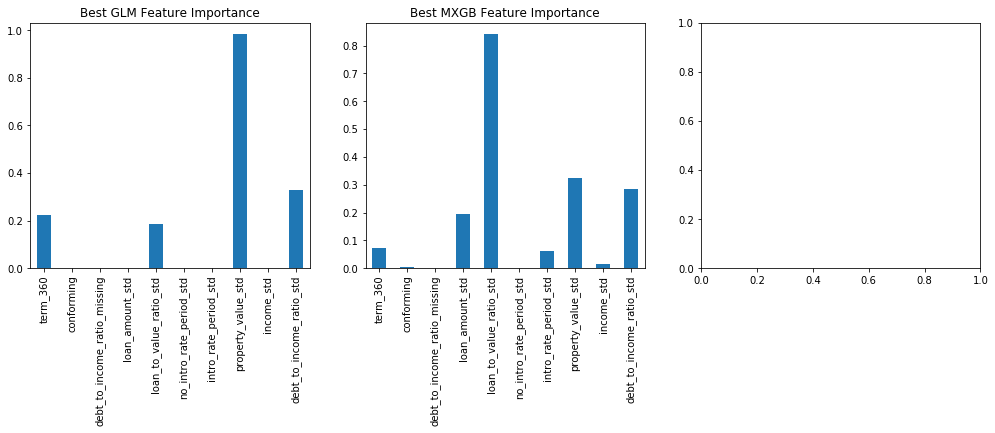

In [92]:
# init 3-pane plot 
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2.2, wspace=0.2)

# plot global FI across three panes
_ = global_feat_imp['GLM Importance'].plot(kind='bar', ax=ax0, title='Best GLM Feature Importance')
_ = global_feat_imp['MXGB Importance'].plot(kind='bar', ax=ax1, title='Best MXGB Feature Importance')
_ = global_fi['EBM Importance'].plot(kind='bar', ax=ax2, title='Best EBM Feature Importance')

#### Compare local feature importance across models

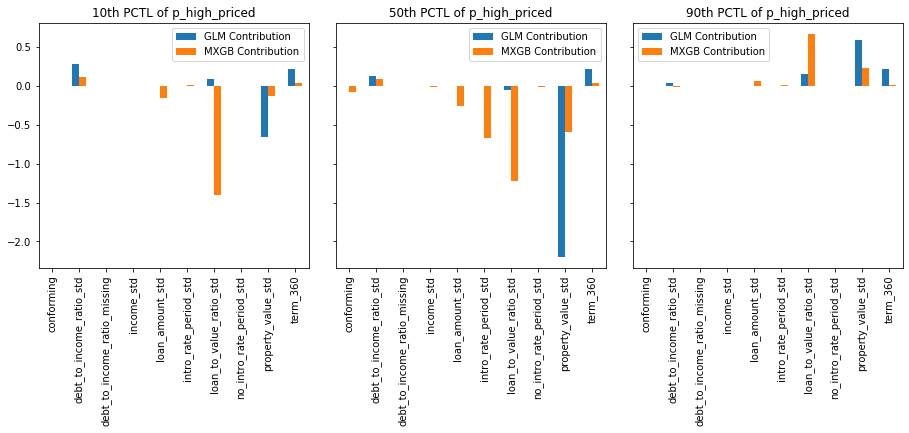

In [93]:
## init 3-pane plot 
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2, wspace=0.1)

# plot comparisons of local FI across 3 panes
_ = local_fi_dict[10].plot(kind='bar', ax=ax0,
                             title='10th PCTL of p_high_priced')

_ = local_fi_dict[50].plot(kind='bar', ax=ax1,
                             title='50th PCTL of p_high_priced')

_ = local_fi_dict[90].plot(kind='bar', ax=ax2,
                             title='90th PCTL of p_high_priced')

#### Utility function for partial dependence

In [94]:
def par_dep(x_name, valid, model, model_type, resolution=20, bins=None):

    """ Creates Pandas DataFrame containing partial dependence or ICE
        for a single input variable.
        :param x_name: Variable for which to calculate partial dependence.
        :param valid: Pandas validation frame.
        :param model: Trained model object (assumes binary classifier).
        :param model_type: Kind of model: h2o, xgb, or ebm.
        :param resolution: The number of points across the domain of xs for which
                           to calculate partial dependence, default 20.
        :param bins: List of values at which to set xs, default 20 equally-spaced
                     points between column minimum and maximum.
        :return: Pandas DataFrame containing partial dependence values.
    """

    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None

    # determine values at which to calculate partial dependence
    if bins is None:
        min_ = valid[x_name].min()
        max_ = valid[x_name].max()
        by = (max_ - min_) / resolution
        # modify max and by
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))
        
    # cache original column values
    col_cache = valid.loc[:, x_name].copy(deep=True)

    # calculate partial dependence
    # by setting column of interest to constant
    # and scoring the altered data and taking the mean of the predictions
    temp_df = valid.copy(deep=True)
    temp_df.loc[:, x_name] = bins[0]
    for j, _ in enumerate(bins):
        if j + 1 < len(bins):
            valid.loc[:, x_name] = bins[j + 1]
            temp_df = temp_df.append(valid, ignore_index=True)

    # return input frame to original cached state
    valid.loc[:, x_name] = col_cache

    # model predictions
    # probably assumes binary classification
    if model_type == 'h2o':
        temp_df['partial_dependence'] = model.predict(h2o.H2OFrame(temp_df))['p1'].as_data_frame()
    if model_type == 'xgb':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict(xgb.DMatrix(temp_df), iteration_range=(0, best_mxgb.best_ntree_limit)), columns=['phat'])
    if model_type == 'ebm':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict_proba(temp_df)[:, 1], columns=['phat'])
    
    return pd.DataFrame(temp_df[[x_name, 'partial_dependence']].groupby([x_name]).mean()).reset_index()

#### Calculate partial dependence for all X and models

In [96]:
# start local timer
pd_tic = time.time()

# init dict to hold results
pd_dict = {}

# cycle through names and model types to calculate par dep
for name in x_name:
    
    print('Calculating partial dependence for %s ...' % name)
    
    # setup a dataframe to hold results
    # use bins from first par_dep() run
    #pd_dict[name] = pd.DataFrame(columns=[name, 'h2o', 'xgb', 'ebm'])
    pd_dict[name] = pd.DataFrame(columns=[name, 'h2o', 'xgb'])
    first_pd = par_dep(name, validation[x_name], best_glm, 'h2o')
    pd_dict[name][name] = first_pd[name]
    bins = first_pd[name]
    pd_dict[name]['h2o'] = first_pd['partial_dependence']
    
    # calculate par dep for remaining models
    pd_dict[name]['xgb'] = par_dep(name, validation[x_name], best_mxgb, 'xgb', bins=bins)['partial_dependence']
    #pd_dict[name]['ebm'] = par_dep(name, validation[x_name], best_ebm, 'ebm', bins=bins)['partial_dependence']
    
print('Done.')

# end local timer
pd_toc = time.time() - pd_tic
print('Partial dependence calculated in %.2f s.' % (pd_toc))

Calculating partial dependence for conforming ...
Calculating partial dependence for debt_to_income_ratio_std ...
Calculating partial dependence for debt_to_income_ratio_missing ...
Calculating partial dependence for income_std ...
Calculating partial dependence for loan_amount_std ...
Calculating partial dependence for intro_rate_period_std ...
Calculating partial dependence for loan_to_value_ratio_std ...
Calculating partial dependence for no_intro_rate_period_std ...
Calculating partial dependence for property_value_std ...
Calculating partial dependence for term_360 ...
Done.
Partial dependence calculated in 401.77 s.


#### Plot partial dependence for all features and models

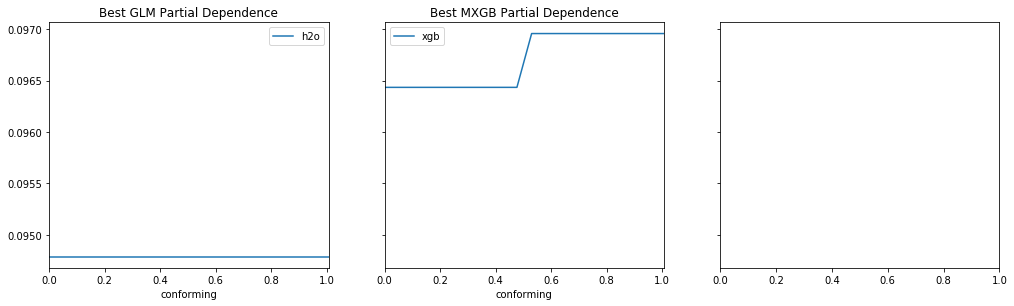

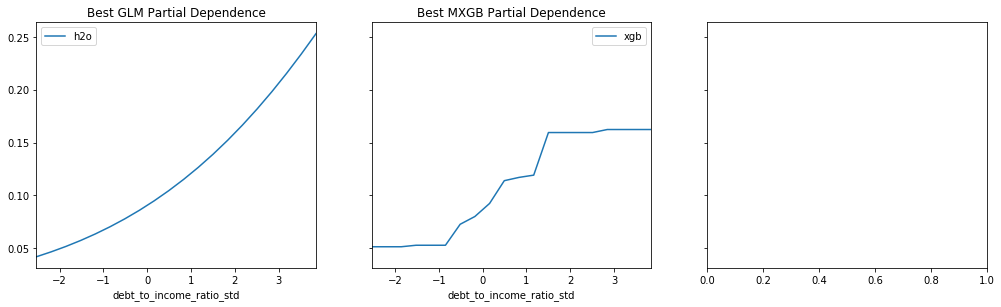

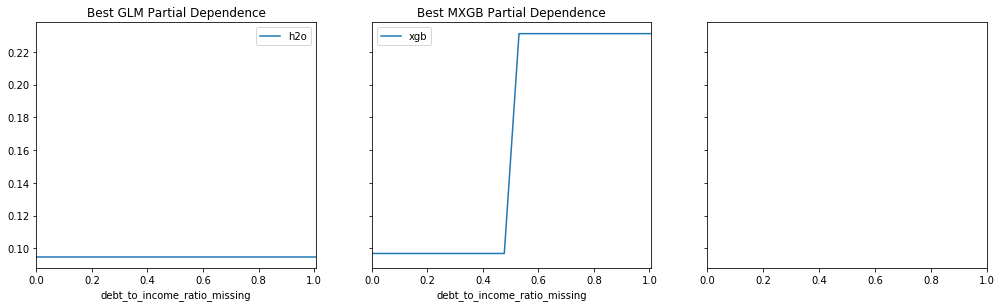

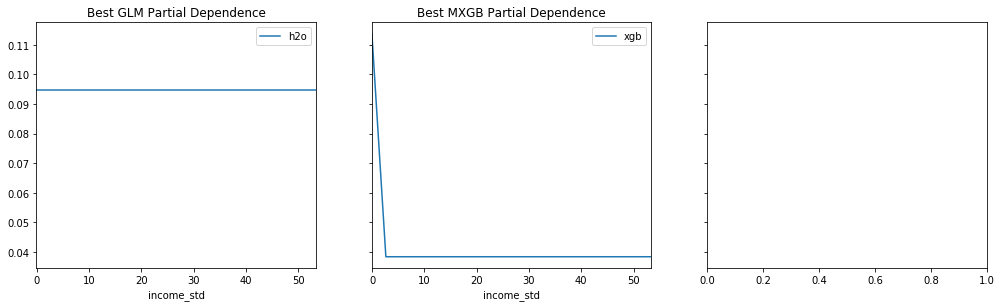

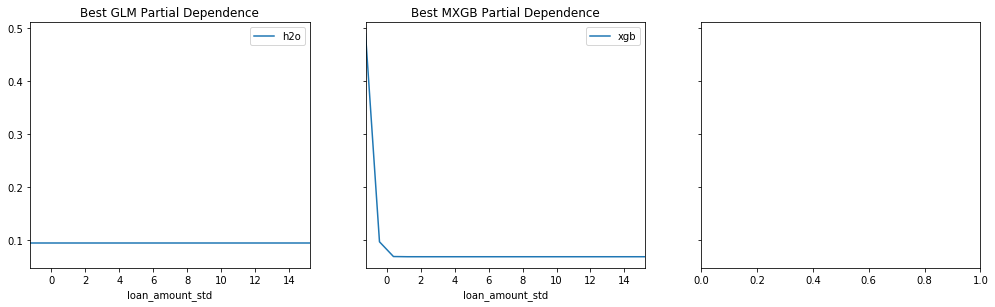

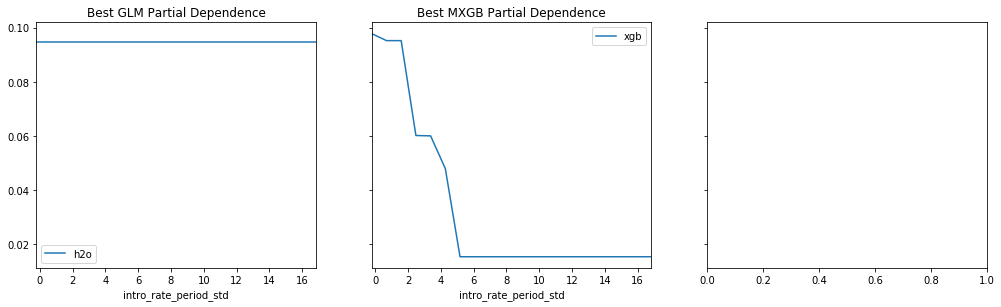

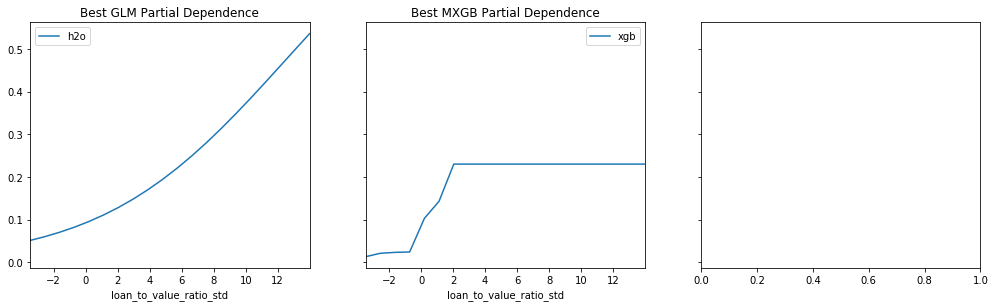

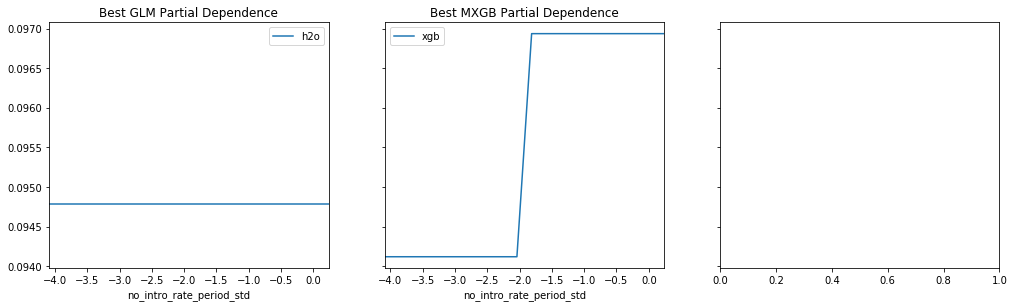

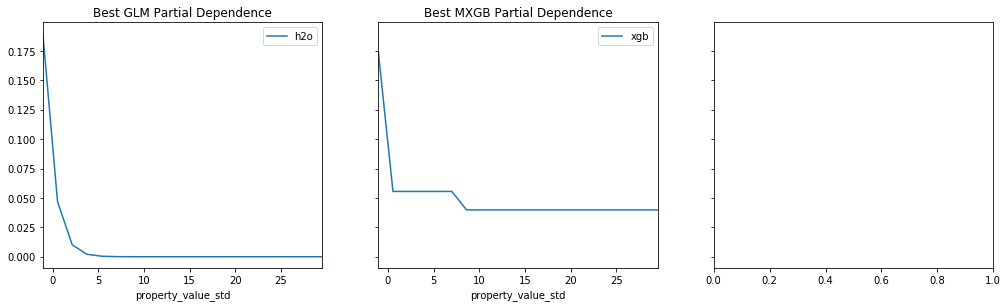

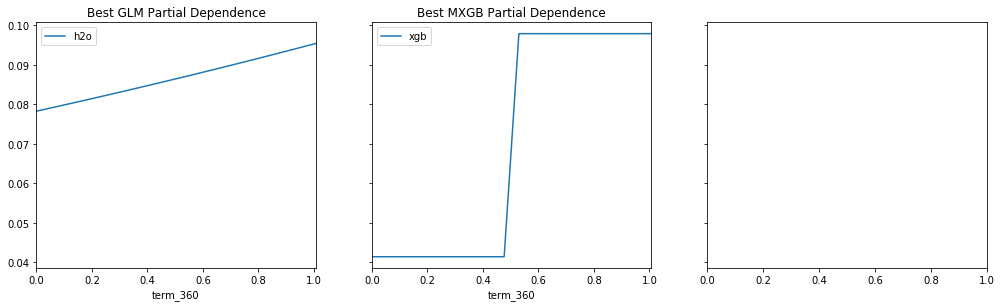

In [97]:
# loop through names to calculate par dep 
for name in x_name:
    
    # init 3-pane plot
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=2.2, wspace=0.2)
  
    # plot par dep from each model across frames
    pd_dict[name].plot(kind='line', x=name, y='h2o', ax=ax0, title='Best GLM Partial Dependence')
    ax0.set_xlabel(name)
    pd_dict[name].plot(kind='line', x=name, y='xgb', ax=ax1, title='Best MXGB Partial Dependence') 
    ax1.set_xlabel(name)
    #pd_dict[name].plot(kind='line', x=name, y='ebm', ax=ax2, title='Best EBM Partial Dependence')
    #ax2.set_xlabel(name)

#### End timer

In [98]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 11262.71 s.


#### Shut down h2o

In [99]:
h2o.cluster().shutdown(prompt=False)

H2O session _sid_949e closed.
